<a href="https://colab.research.google.com/github/k3vin527/project/blob/master/dryscalp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob 
import tensorflow as tf
import PIL
from PIL import ImageDraw

from keras import models
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten, Activation, BatchNormalization,Input,Add,ZeroPadding2D,AveragePooling2D,GlobalMaxPooling2D,MaxPool2D
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input, decode_predictions


from sklearn.metrics import confusion_matrix

In [3]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/dry_scalp'
test_path = '/content/drive/MyDrive/Final_Project/Test/dry_scalp'

In [4]:
subject = train_path.split('/')[-1]
subject

'dry_scalp'

In [5]:
labels=pd.Series(os.listdir(train_path))

labels=labels.sort_values()
labels=labels.to_list()
labels

['dry_scalp_0', 'dry_scalp_1', 'dry_scalp_2', 'dry_scalp_3']

In [6]:
image_height = 224  # 이미지 높이
image_width = 224   # 이미지 넓이
batch_size = 64     # batch size
epochs  = 20  # trining 횟수

In [7]:
# ImageDataGenerator 클래스를 통해 train_datagen, val_datagen 인스턴스를 생성.
# 픽셀 값을 0~1 범위로 변환

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# train_datagen 인스턴스를 통해 train dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 training_set 객체를 생성.
train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Final_Project/Train_data/dry_scalp',
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


# val_datagen 인스턴스를 통해 test dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체를 생성.
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Final_Project/Test/dry_scalp',
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='categorical')

#val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성.
val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/Final_Project/Validation/dry_scalp',
                                           target_size=(image_width, image_height),
                                           batch_size=batch_size,
                                           shuffle=False,
                                           class_mode='categorical')

Found 20438 images belonging to 4 classes.
Found 1819 images belonging to 4 classes.
Found 3188 images belonging to 4 classes.


In [9]:
class_path = glob.glob(train_path + '/*')
class_path

['/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_2',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_3',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_1',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_0']

In [10]:
len(glob.glob('/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_2/*'))

5486

In [11]:
# 각각의 data set 이 만들어 내는 이미지의 클래스 인덱스 확인
print(f'train set의 이미지 클래스: {train_set.class_indices}')
print(f'test set의 이미지 클래스: {test_set.class_indices}')
print(f'validation set의 이미지 클래스: {val_set.class_indices}')

train set의 이미지 클래스: {'dry_scalp_0': 0, 'dry_scalp_1': 1, 'dry_scalp_2': 2, 'dry_scalp_3': 3}
test set의 이미지 클래스: {'dry_scalp_0': 0, 'dry_scalp_1': 1, 'dry_scalp_2': 2, 'dry_scalp_3': 3}
validation set의 이미지 클래스: {'dry_scalp_0': 0, 'dry_scalp_1': 1, 'dry_scalp_2': 2, 'dry_scalp_3': 3}


In [12]:
classNum = []
fileNum = []
for path in class_path :
    fileNum.append(len(glob.glob(path + '/*')))
    classNum.append(int(path.split('_')[-1]))

label_dic = dict(zip(classNum, fileNum))
label_dic

{0: 4588, 1: 4435, 2: 5486, 3: 5929}

In [13]:
#class weight 지정 함수
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune

def create_class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        score = round(score, 3)
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

In [14]:
class_weight = create_class_weight(label_dic)
class_weight

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [15]:
# 파라미터 설정
classes = len(train_set.class_indices)


In [16]:
conv_base = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
conv_base.summary()

234561536/234545216 [==============================] - 3s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [17]:
model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.summary()


# x2 = resnet152.output
# x2 = Flatten()(x2)
# x2 = Dense(128,activation='relu')(x2)
# x2 = Dropout(0.3)(x2)
# x2 = Dense(1,activation='sigmoid')(x2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 71,177,348
Trainable params: 71,033,604
Non-trainable params: 143,744
_________________________________________________________________


In [18]:
for i, layer in enumerate(conv_base.layers) :
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad
46 

In [19]:
for layer in conv_base.layers : 
  layer.trainable = False 

In [20]:
for layer in conv_base.layers[528:] :
  layer.trainable = True

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 71,177,348
Trainable params: 27,816,580
Non-trainable params: 43,360,768
_________________________________________________________________


In [22]:
# optimizer 정의

opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)

In [23]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('/content/drive/MyDrive/dryscalp_resnet1.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_acc', patience=7)

# callback 정의
callbacks= [modelCheckpoint,monitor_val_acc]

In [24]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])

In [ ]:
resnet152v2_history =model.fit_generator(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=callbacks
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
37/37 [==============================] - 1086s 29s/step - loss: 1.3444 - acc: 0.4565 - val_loss: 1.2919 - val_acc: 0.5299


In [ ]:
# resnet_model 모델 평가
(test_loss, test_accuracy) = model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

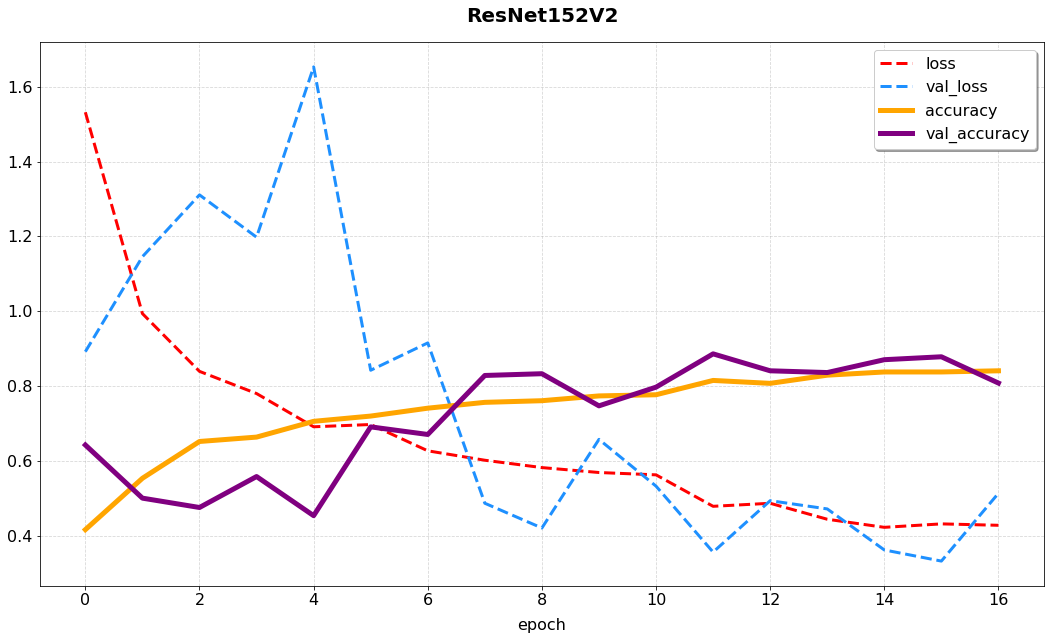

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(resnet152v2_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(resnet152v2_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(resnet152v2_history.history['acc'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(resnet152v2_history.history['val_acc'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('ResNet152V2', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_set)
classes = test_set.classes[test_set.index_array]
y_pred = np.argmax(Y_pred, axis=1)

result_dict = dict(map(reversed, test_set.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

-- Confusion Matrix --
[[  2  33  22  19]
 [ 36 236 234 127]
 [ 42 274 294 174]
 [ 24 107 124  71]]
-- Classification Report --
              precision    recall  f1-score   support

 dry_scalp_0       0.02      0.03      0.02        76
 dry_scalp_1       0.36      0.37      0.37       633
 dry_scalp_2       0.44      0.38      0.40       784
 dry_scalp_3       0.18      0.22      0.20       326

    accuracy                           0.33      1819
   macro avg       0.25      0.25      0.25      1819
weighted avg       0.35      0.33      0.34      1819



Text(0.5, 1.0, 'dry_scalp_confusion matrix')

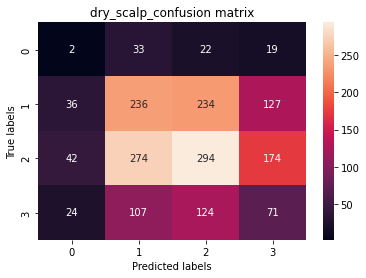

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d' )
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title(f'{subject}_confusion matrix')